## Feature to Phenotype
* Given a list of features produced by the GENIE_Analysis notebook
* Fetch phenotypes for each variant
* Filter to only the phenotypes found by `cgi`
* Plot a simple summary

In [1]:
from g2p_client import G2PDatabase
from __future__ import division
import pandas as pd


In [2]:
# from the GENIE_Analysis notebook
# grouped_evidence_df.to_pickle("grouped_evidence_df.pkl")
grouped_evidence_df = pd.read_pickle("grouped_evidence_df.pkl")
INDEX = 'associations'
HOST = 'elastic'
DATABASE = G2PDatabase(HOST, INDEX)

In [3]:
# structure of existing dataset
print len(grouped_evidence_df)
grouped_evidence_df.head()

8060


,feature_chromosome,feature_start,feature_ref,feature_alt,source,evidence_label,evidence_count
19,1,8073509,C,A,civic,C,1
22,1,11169361,C,G,cgi,D,1
23,1,11174420,C,T,cgi,C,1
25,1,11177096,C,A,civic,D,3
26,1,11182158,A,C,oncokb,D,1


### Enrichment
* Lookup phenotype counts for each feature
* denormalize into a new data frame

In [4]:
# for example, lets get the phenotype(s) associated with the first record
row = grouped_evidence_df.head(1).to_dict('record')[0]
DATABASE.feature_to_phenotypes(row)

[{'phenotype_description': u'cholangiocarcinoma',
  'phenotype_evidence_count': 1,
  'phenotype_ontology_id': u'DOID:4947'}]

In [5]:
def add_phenotypes(df):
    """iterate through df. denormalize, create new row for each phenotype """
    for index, row  in df.iterrows():
        phenotypes = DATABASE.feature_to_phenotypes(row)
        for phenotype in phenotypes:        
            phenotype.update(row)
            yield phenotype

# create new dataframe, note that feature rows are duplicated for each matched phenotype            
grouped_evidence_phenotypes_df = pd.DataFrame(add_phenotypes(grouped_evidence_df))

# save our work, for downstream analysis and plotting
grouped_evidence_phenotypes_df.to_pickle("grouped_evidence_phenotypes_df.pkl")

# show summary
print 'There are {} unique feature phenotype items'.format(len(grouped_evidence_phenotypes_df))
grouped_evidence_phenotypes_df

There are 9000 unique feature phenotype items


,evidence_count,evidence_label,feature_alt,feature_chromosome,feature_ref,feature_start,phenotype_description,phenotype_evidence_count,phenotype_ontology_id,source
0,1,C,A,1,C,8073509,cholangiocarcinoma,1,DOID:4947,civic
1,1,D,G,1,C,11169361,cancer,1,DOID:162,cgi
2,1,C,T,1,C,11174420,bladder,1,UBERON:0018707,cgi
3,3,D,A,1,C,11177096,breast cancer,3,DOID:1612,civic
4,1,D,C,1,A,11182158,renal cell carcinoma,1,DOID:4450,oncokb
5,1,C,T,1,G,11182179,Renal,1,LNC:LP34712-7,cgi
6,1,D,A,1,G,11184573,renal cell carcinoma,1,DOID:4450,oncokb
7,1,D,T,1,G,11184573,cancer,1,DOID:162,cgi
8,1,D,T,1,G,11184573,endometrial adenocarcinoma,1,DOID:2870,civic
9,1,D,A,1,G,11184580,melanoma,1,DOID:1909,civic


### Analysis of 'phenotyped' evidence

In [11]:
# grouped_evidence_phenotypes_df = pd.read_pickle("grouped_evidence_phenotypes_df.pkl")
print phenotyped_evidence_df.query('feature_start==140453136')['phenotype_evidence_count'].sum()
print phenotyped_evidence_df.query('feature_start==140453136')['evidence_count'].sum()
phenotyped_evidence_df.head(4)

583
3330


,evidence_count,evidence_label,feature_alt,feature_chromosome,feature_ref,feature_start,phenotype_evidence_count,phenotype_ontology_id,source
phenotype_description,,,,,,,,,
melanoma,153,D,T,7,A,140453136,152,DOID:1909,jax
colorectal cancer,153,D,T,7,A,140453136,127,DOID:9256,jax
melanoma,50,D,A,7,G,140494248,82,DOID:1909,jax
cancer,26,D,C,13,G,28623550,67,DOID:162,jax


#### Filter for only CGI 
* limit to only those phenotypes found in cgi

In [9]:
print 'all phenotype_ontology_id len:', len(grouped_evidence_phenotypes_df.groupby(['phenotype_ontology_id']).groups.keys()) 
print 'all phenotype_description len:', len(grouped_evidence_phenotypes_df.groupby(['phenotype_description']).groups.keys()) 
print 'all  len:', len(grouped_evidence_phenotypes_df) 

all phenotype_ontology_id len: 225
all phenotype_description len: 225
all  len: 9000


In [25]:
# filter out only cgi phenotypes
cgi_phenotypes = grouped_evidence_phenotypes_df.query('source=="cgi"').groupby(['phenotype_description']).groups.keys()
cgi_phenotypes = pd.Series(cgi_phenotypes)
cgi_phenotypes_only = pd.DataFrame(grouped_evidence_phenotypes_df[(grouped_evidence_phenotypes_df.phenotype_description.isin(cgi_phenotypes))])

In [26]:
print 'cgi phenotype_ontology_id len:', len(cgi_phenotypes_only.groupby(['phenotype_ontology_id']).groups.keys()) 
print 'cgi phenotype_description len:', len(cgi_phenotypes_only.groupby(['phenotype_description']).groups.keys()) 
print 'cgi evidence len:', len(cgi_phenotypes_only)

cgi phenotype_ontology_id len: 43
cgi phenotype_description len: 43
cgi evidence len: 1680


In [27]:
# enrich with the cgi phenotype
original_cgi_phenotypes = DATABASE.original_cgi_phenotypes()

def add_cgi_phenotype(row):
    return original_cgi_phenotypes[row['phenotype_ontology_id']]
    
cgi_phenotypes_only['cgi_phenotype'] = cgi_phenotypes_only.apply(add_cgi_phenotype, axis=1) 

In [29]:
cgi_phenotypes_only.head(4)

,evidence_count,evidence_label,feature_alt,feature_chromosome,feature_ref,feature_start,phenotype_description,phenotype_evidence_count,phenotype_ontology_id,source,cgi_phenotype
1,1,D,G,1,C,11169361,cancer,1,DOID:162,cgi,SOLID
2,1,C,T,1,C,11174420,bladder,1,UBERON:0018707,cgi,BLCA
5,1,C,T,1,G,11182179,Renal,1,LNC:LP34712-7,cgi,R
7,1,D,T,1,G,11184573,cancer,1,DOID:162,cgi,SOLID


### quick graph to show results

In [45]:
from IPython.display import set_matplotlib_formats
from __future__ import division
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  The resulting plots will then also be stored in the notebook document.
%matplotlib inline

In [62]:
cgi_phenotypes_summary =  pd.DataFrame(cgi_phenotypes_only.groupby(['cgi_phenotype', 'source'])['evidence_count'].sum())
cmp = plt.cm.get_cmap('jet')
s_sort = cgi_phenotypes_summary.groupby(level=[0]).sum().sort_values(by=['evidence_count'],ascending=False)
cgi_phenotypes_summary = cgi_phenotypes_summary.reindex(index=s_sort.index, level=0).unstack(fill_value=0)
# .plot.bar(stacked=True, cmap=cmp)
# cgi_phenotypes_summary = cgi_phenotypes_summary.unstack(fill_value=0)
#cgi_phenotypes_summary =  cgi_phenotypes_summary.sort_values(by=['cgi_phenotype', 'source'], ascending=False)
cgi_phenotypes_summary.head(4)

evidence_count                                  
source                   cgi civic   jax molecularmatch oncokb
cgi_phenotype                                                 
SOLID                     79   136  3224              0      0
NSCLC                     63   534  2074              5     57
LUAD                      63   249  1385            869      0
L                         54   141   991              0      0

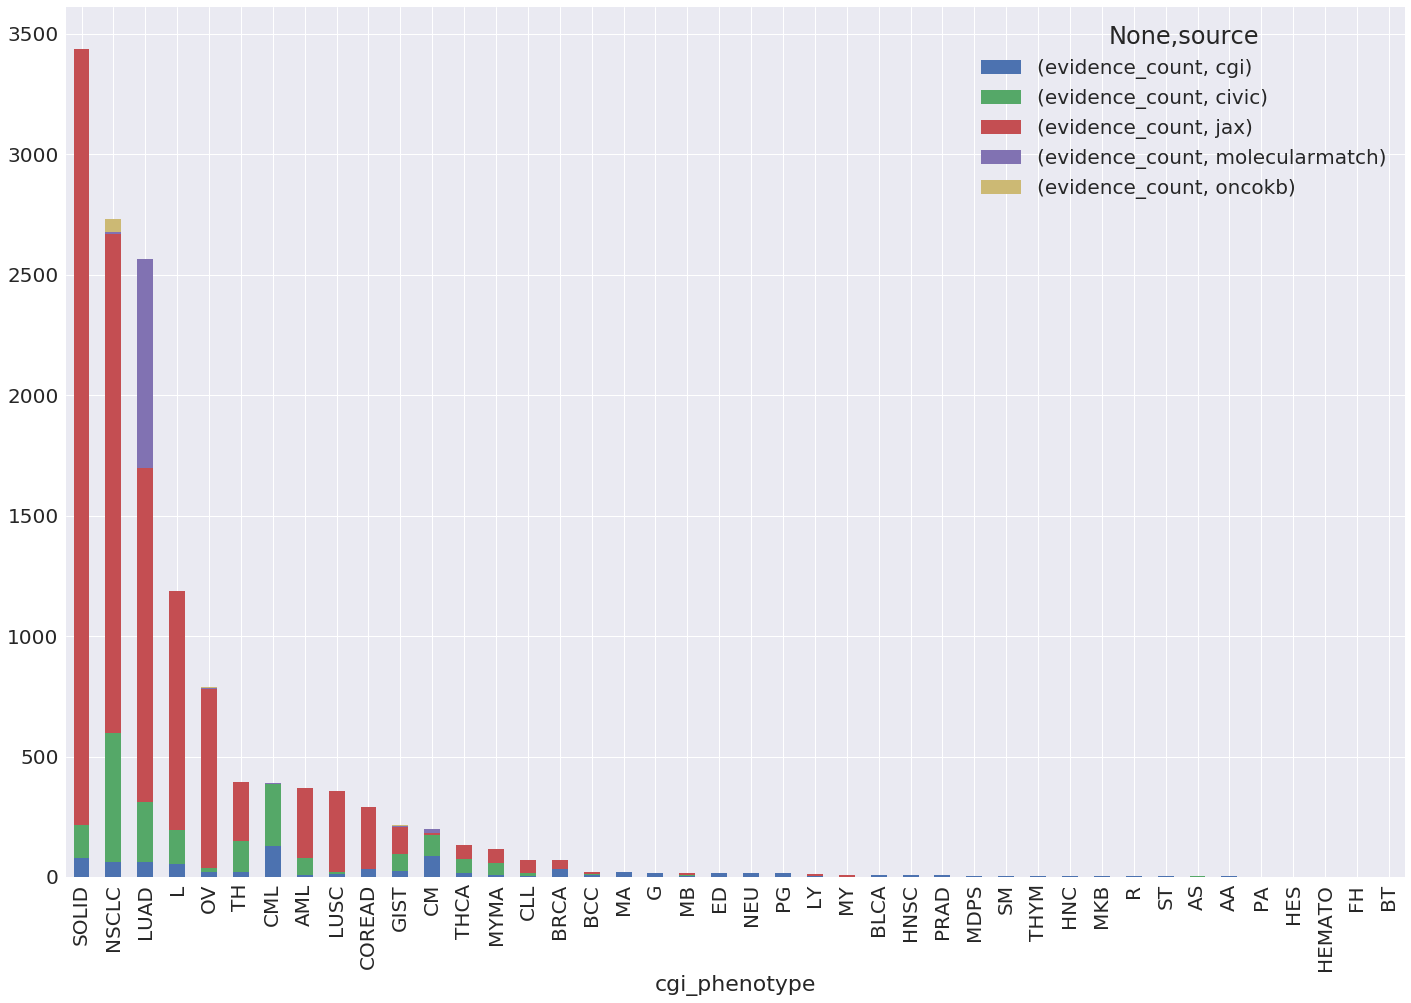

In [65]:
sns.set(font_scale=2)
cgi_phenotypes_summary.plot(kind='bar',  stacked=True,  figsize=(24, 16))